In [1]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import seaborn as sns

from tqdm import tqdm
import random

# Objective
The goal of this task is to improve classification performance by fine-tuning a pre-trained CLIP model on a small subset of the EuroSAT dataset. Unlike zero-shot classification, we will use a limited number of labeled images for each land cover class to enhance model accuracy.

The dataset remains the EuroSAT dataset, but for fine-tuning, we will carefully select a small number of images per class. This study is structured into several phases, each progressively exploring different ways to enhance performance.

1. **Baseline Linear Probing and Few-Shot Experiments** – We start with a simple linear probing approach, freezing CLIP’s backbone and training a linear classifier on extracted embeddings. We also analyze the effect of different training dataset sizes (5, 10, and 20 images per class) to determine how much labeled data impacts performance.
2. **Architectural Experiments** – We explore alternative classifier architectures, comparing a single-layer linear model, a multi-layer perceptron (MLP), and logistic regression.
3. **Data Augmentation** – We apply basic augmentations such as hue/saturation/contrast shifts and Gaussian noise to evaluate their impact on model generalization.
4. **Advanced Fine-Tuning Approaches** – We investigate deeper fine-tuning strategies, including unfreezing the last few layers of CLIP and contrastive fine-tuning of embeddings.

This structured approach allows us to systematically analyze and refine the few-shot learning process, identifying the most effective improvements for satellite image classification.


## Baseline: Linear Probing with Single-Layer Neural Network

### Introduction
In this first experiment, we perform linear probing, where we freeze the CLIP backbone and train a simple single-layer neural network as a classifier. This method allows us to evaluate how well CLIP’s feature extraction capabilities can be leveraged with minimal labeled data.

We conduct experiments using three different training dataset sizes: **5, 10, and 20 images per class**. This helps us analyze how the number of training samples affects model performance. The classifier is trained for **1000 epochs**, and we evaluate the model on **50 randomly selected images per class** to measure accuracy and compare confusion matrices.


In [2]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

for param in clip_model.parameters():
    param.requires_grad = False

print("CLIP model loaded and backbone frozen.")

CLIP model loaded and backbone frozen.


In [3]:
classes = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

In [4]:
def extract_image_features_with_text(image_paths, class_labels, model, processor, device):
    images = [Image.open(img_path).convert("RGB") for img_path in image_paths]
    text_inputs = [f"A satellite image of {cls}" for cls in class_labels]

    inputs = processor(text=text_inputs, images=images, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=inputs["pixel_values"])
    
    return image_features.cpu()

In [5]:
def sample_few_shot_data(dataset_path, classes, num_samples):
    sampled_data = []
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        sampled_images = random.sample(image_paths, num_samples)
        sampled_data.extend([(img, cls) for img in sampled_images])
    return sampled_data

In [6]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

In [7]:
training_sizes = [5, 10, 20]
results = {}

for num_samples in training_sizes:
    print(f"Training with {num_samples} images per class...")
    
    few_shot_data = sample_few_shot_data("2750/", classes, num_samples)
    few_shot_df = pd.DataFrame(few_shot_data, columns=["Image Path", "Class"])
    
    image_features = extract_image_features_with_text(few_shot_df["Image Path"].tolist(), classes, clip_model, clip_processor, device)
    labels = torch.tensor([classes.index(cls) for cls in few_shot_df["Class"]], dtype=torch.long).to(device)
    
    classifier = LinearClassifier(input_dim=image_features.shape[1], num_classes=len(classes)).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    
    num_epochs = 1000
    losses = []
    
    for epoch in range(num_epochs):
        classifier.train()
        optimizer.zero_grad()
        
        outputs = classifier(image_features.to(device))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    results[num_samples] = {
        "model": classifier,
        "losses": losses
    }

Training with 5 images per class...
Epoch [1/1000], Loss: 2.3251
Epoch [101/1000], Loss: 0.3001
Epoch [201/1000], Loss: 0.1024
Epoch [301/1000], Loss: 0.0540
Epoch [401/1000], Loss: 0.0343
Epoch [501/1000], Loss: 0.0241
Epoch [601/1000], Loss: 0.0180
Epoch [701/1000], Loss: 0.0140
Epoch [801/1000], Loss: 0.0113
Epoch [901/1000], Loss: 0.0093
Training with 10 images per class...
Epoch [1/1000], Loss: 2.3938
Epoch [101/1000], Loss: 0.4369
Epoch [201/1000], Loss: 0.1756
Epoch [301/1000], Loss: 0.0949
Epoch [401/1000], Loss: 0.0603
Epoch [501/1000], Loss: 0.0423
Epoch [601/1000], Loss: 0.0315
Epoch [701/1000], Loss: 0.0246
Epoch [801/1000], Loss: 0.0197
Epoch [901/1000], Loss: 0.0162
Training with 20 images per class...
Epoch [1/1000], Loss: 2.3608
Epoch [101/1000], Loss: 0.5285
Epoch [201/1000], Loss: 0.2483
Epoch [301/1000], Loss: 0.1466
Epoch [401/1000], Loss: 0.0973
Epoch [501/1000], Loss: 0.0696
Epoch [601/1000], Loss: 0.0524
Epoch [701/1000], Loss: 0.0410
Epoch [801/1000], Loss: 0.03

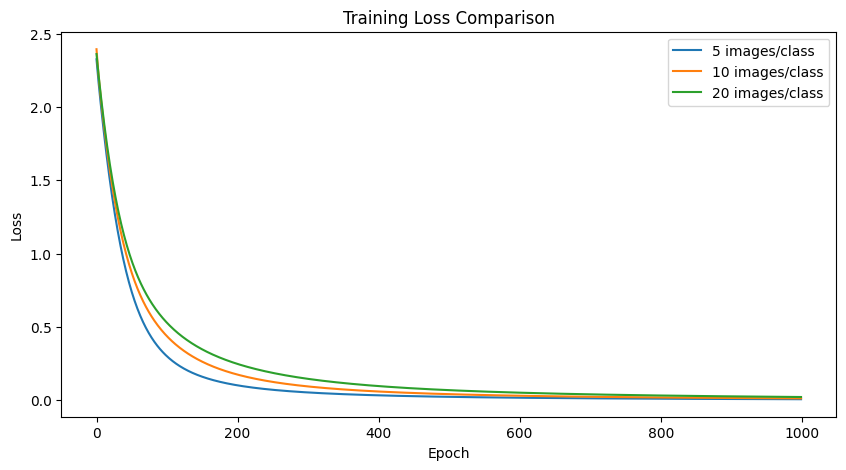

In [8]:
plt.figure(figsize=(10,5))
for num_samples, result in results.items():
    plt.plot(result["losses"], label=f"{num_samples} images/class")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

In [9]:
test_data = sample_few_shot_data("2750/", classes, num_samples=300)
test_df = pd.DataFrame(test_data, columns=["Image Path", "Class"])
test_features = extract_image_features_with_text(test_df["Image Path"].tolist(), classes, clip_model, clip_processor, device).to(device)
test_labels = torch.tensor([classes.index(cls) for cls in test_df["Class"]], dtype=torch.long).to(device)

for num_samples, result in results.items():
    classifier = result["model"]
    classifier.eval()
    with torch.no_grad():
        test_outputs = classifier(test_features)
        predictions = torch.argmax(test_outputs, dim=1)
        accuracy = (predictions == test_labels).float().mean().item()
    print(f"Test Accuracy ({num_samples} images/class): {accuracy * 100:.2f}%")

Test Accuracy (5 images/class): 79.23%
Test Accuracy (10 images/class): 82.00%
Test Accuracy (20 images/class): 87.50%


### Observations
- The **training loss curve decreases faster** with more training samples, suggesting that the model converges more quickly when given more data.
- As expected, the **best performance is achieved with 20 images per class**, but the improvement in accuracy diminishes as we increase the dataset size.
- Even with just **5 images per class**, the model performs well, showing that CLIP's feature representations are highly transferable even with limited labeled data.
- The results indicate that **adding more data helps, but with diminishing returns**, which is important for deciding optimal dataset sizes in resource-limited scenarios.

These results provide a foundation for further exploration in model architecture and data augmentation techniques to improve classification performance.


## Architectural Experiments: Comparing Different Classifiers

### Motivation

In the previous experiment, we used a simple linear classifier to map CLIP embeddings to EuroSAT land cover classes. While this approach demonstrated strong performance, it is possible that a different classification architecture could yield even better results.

In this section, we explore three different classifier architectures:

1. **Single-Layer Linear Model:** This is the baseline from the previous section. It serves as a simple, lightweight approach to classification.
2. **Multi-Layer Perceptron (MLP):** A deeper network with at least one hidden layer can capture more complex relationships in CLIP’s feature space.
3. **Logistic Regression:** A classical machine learning approach, using CLIP’s embeddings as input without additional neural network layers.

By testing these different models, we aim to determine if increasing model complexity provides meaningful improvements in classification accuracy or if the extracted CLIP features are already sufficient for strong performance with a simple classifier.

We will train each classifier using the best-performing dataset size from the previous section (20 images per class) and compare accuracy and confusion matrices across all three models.

In [10]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [11]:
def sample_test_data(dataset_path, classes, num_samples=300):
    test_data = []
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        sampled_images = random.sample(image_paths, num_samples)
        test_data.extend([(img, cls) for img in sampled_images])
    return test_data

test_data = sample_test_data("2750/", classes, num_samples=300)
test_df = pd.DataFrame(test_data, columns=["Image Path", "Class"])
test_features = extract_image_features_with_text(test_df["Image Path"].tolist(), classes, clip_model, clip_processor, device).to(device)
test_labels = torch.tensor([classes.index(cls) for cls in test_df["Class"]], dtype=torch.long).to(device)


In [12]:
models = {
    "Linear": LinearClassifier,
    "MLP": MLPClassifier,
}

results = {}
num_samples = 20

def train_classifier(model_class):
    classifier = model_class(input_dim=image_features.shape[1], num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    
    for epoch in range(1000):
        classifier.train()
        optimizer.zero_grad()
        
        outputs = classifier(image_features.to(device))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    return classifier

In [13]:
for name, model_class in models.items():
    print(f"Training {name} classifier...")
    results[name] = train_classifier(model_class)

Training Linear classifier...
Training MLP classifier...


In [14]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(image_features.cpu().numpy(), labels.cpu().numpy())
results["Logistic Regression"] = log_reg

Test Accuracy (Linear): 87.93%


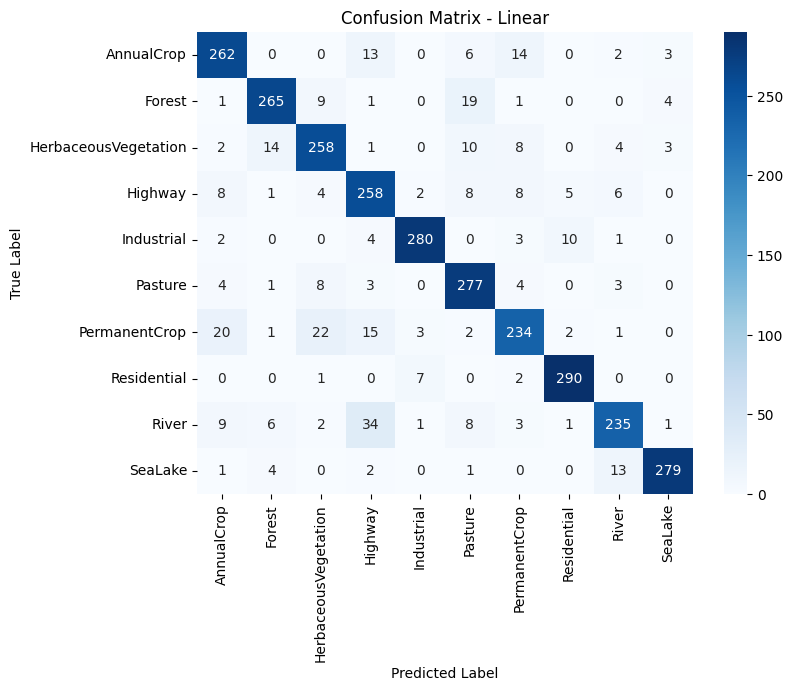

Test Accuracy (MLP): 87.47%


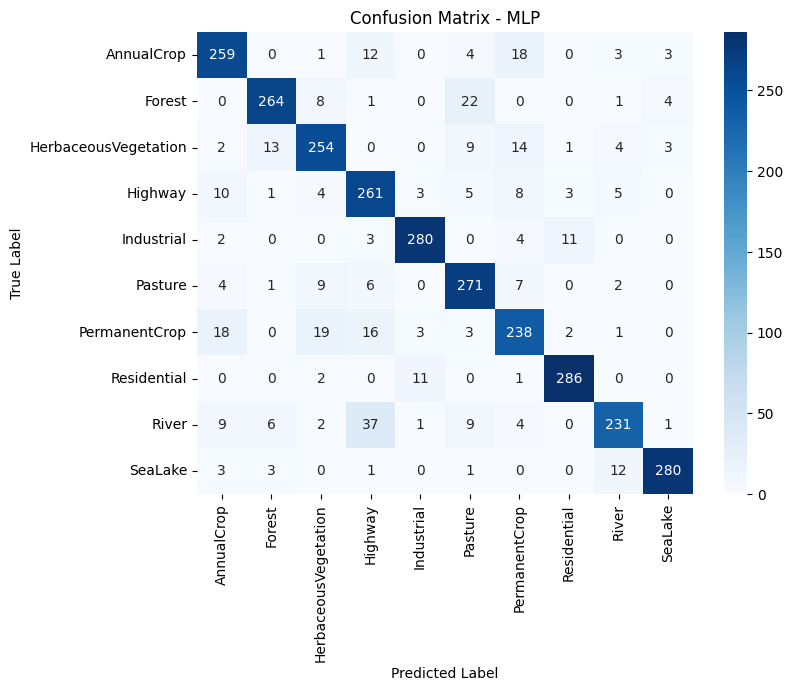

Test Accuracy (Logistic Regression): 86.83%


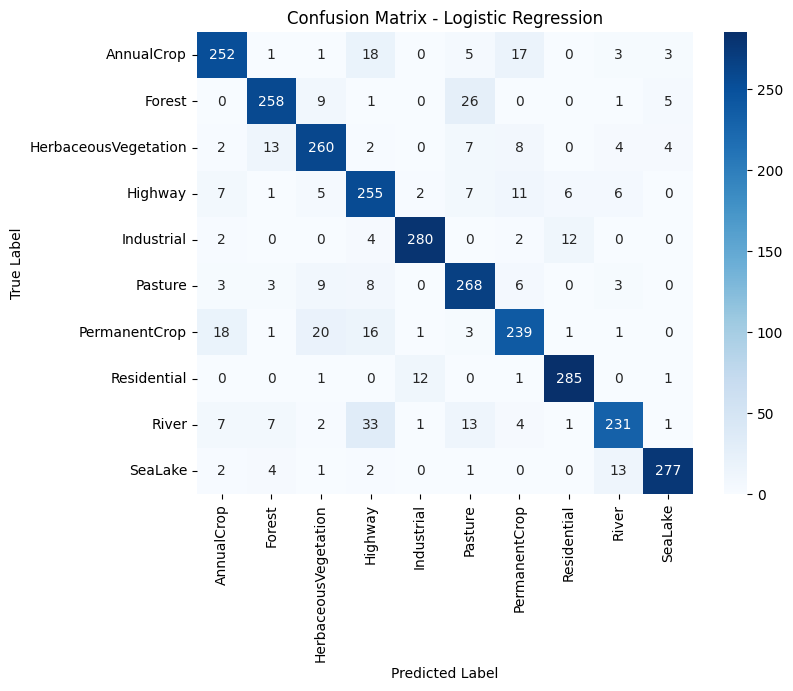

In [15]:
for name, classifier in results.items():
    if name == "Logistic Regression":
        predictions = classifier.predict(test_features.cpu().numpy())
    else:
        classifier.eval()
        with torch.no_grad():
            outputs = classifier(test_features.to(device))
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    
    accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
    print(f"Test Accuracy ({name}): {accuracy * 100:.2f}%")
    
    cm = confusion_matrix(test_labels.cpu().numpy(), predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

### Observations

- The test accuracy results are quite close for all three models, indicating that CLIP’s feature representations are strong enough that even simple classifiers can perform well.
- The **Linear model achieved the highest accuracy**, respecting the indication of the researchers in their paper.
- We will proceed with the linear classifier for the next experiments.

These results provide a foundation for the next step, where we investigate whether data augmentation can further enhance performance.


## Data Augmentation: Improving Generalization

### Motivation

In few-shot learning, the model has access to only a small number of labeled images per class. This limitation makes the model prone to **overfitting**, where it memorizes the limited training samples instead of learning generalizable patterns.

To address this, we will apply **data augmentation**, which artificially expands the dataset by modifying images in ways that retain their semantic meaning while introducing variability. The goal is to make the model more robust and improve its generalization ability.

We will explore the following augmentations:

- **Hue/Saturation/Contrast Adjustments**: These changes simulate variations in lighting conditions and sensor inconsistencies in satellite imagery.
- **Gaussian Noise**: Adding slight random noise to images helps the model become more invariant to small pixel-level perturbations.

By incorporating these augmentations during training, we expect to improve the model’s ability to classify unseen images more accurately.


In [16]:
def augment_hue_saturation_contrast(image):
    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))
    return image

def augment_gaussian_noise(image):
    np_image = np.array(image)
    noise = np.random.normal(0, 10, np_image.shape).astype(np.uint8)
    noisy_image = np.clip(np_image + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

In [17]:
def sample_augmented_data(dataset_path, classes, num_samples=20, augmentation=None):
    augmented_data = []
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        sampled_images = random.sample(image_paths, num_samples)
        
        for img_path in sampled_images:
            image = Image.open(img_path).convert("RGB")
            if augmentation:
                image = augmentation(image)
            augmented_data.append((image, cls))
    return augmented_data

In [18]:
hue_sat_data = sample_augmented_data("2750/", classes, augmentation=augment_hue_saturation_contrast)
gaussian_data = sample_augmented_data("2750/", classes, augmentation=augment_gaussian_noise)

In [19]:
def extract_image_features_from_list(image_list, class_list, model, processor, device):
    text_inputs = [f"A satellite image of {cls}" for cls in class_list]

    inputs = processor(images=image_list, text=text_inputs, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=inputs["pixel_values"])
    
    return image_features.cpu()

In [20]:
hue_sat_features = extract_image_features_from_list([img for img, _ in hue_sat_data], classes, clip_model, clip_processor, device)
gaussian_features = extract_image_features_from_list([img for img, _ in gaussian_data], classes, clip_model, clip_processor, device)

In [21]:
labels = torch.tensor([classes.index(cls) for _, cls in hue_sat_data], dtype=torch.long).to(device)

def train_mlp_with_features(features):
    classifier = LinearClassifier(input_dim=features.shape[1], num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    
    for epoch in range(1000):
        classifier.train()
        optimizer.zero_grad()
        
        outputs = classifier(features.to(device))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    return classifier

In [22]:
mlp_hue_sat = train_mlp_with_features(hue_sat_features)
mlp_gaussian = train_mlp_with_features(gaussian_features)

In [23]:
test_data = sample_test_data("2750/", classes, num_samples=300)
test_df = pd.DataFrame(test_data, columns=["Image Path", "Class"])
test_features = extract_image_features_with_text(test_df["Image Path"].tolist(), classes, clip_model, clip_processor, device).to(device)
test_labels = torch.tensor([classes.index(cls) for cls in test_df["Class"]], dtype=torch.long).to(device)

def evaluate_model(model, test_features, test_labels, name):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    
    accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
    print(f"Test Accuracy ({name}): {accuracy * 100:.2f}%")
    
    cm = confusion_matrix(test_labels.cpu().numpy(), predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

Test Accuracy (MLP with Hue/Saturation/Contrast): 88.07%


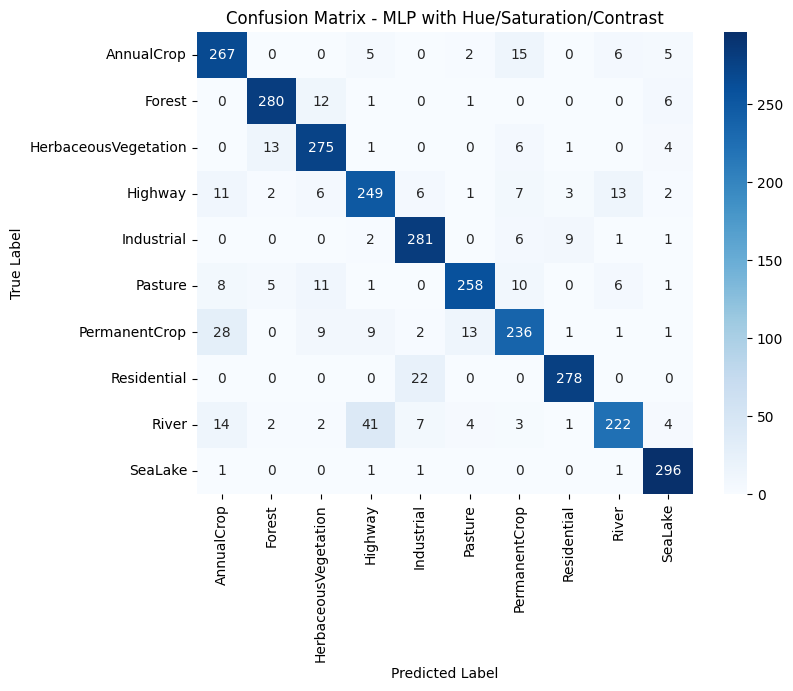

Test Accuracy (MLP with Gaussian Noise): 57.30%


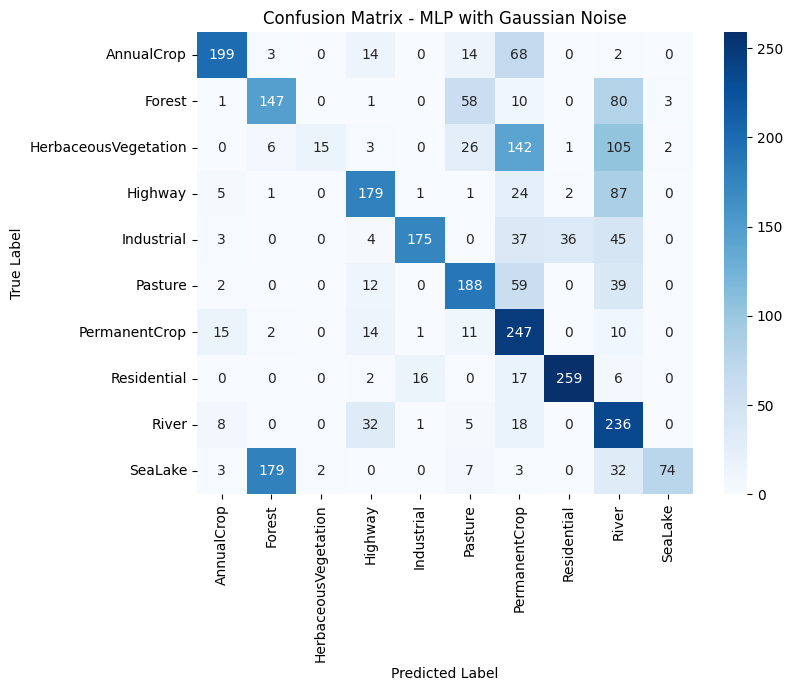

In [24]:
evaluate_model(mlp_hue_sat, test_features, test_labels, "MLP with Hue/Saturation/Contrast")
evaluate_model(mlp_gaussian, test_features, test_labels, "MLP with Gaussian Noise")

#### **Analysis**
- The **hue/saturation/contrast augmentation** effectively enhances model performance by introducing realistic variations in image color and contrast. This helps prevent overfitting while maintaining meaningful visual patterns.
- The **Gaussian noise augmentation** significantly reduces accuracy. This is likely because satellite images rely heavily on clear spatial details, and adding pixel-level noise degrades essential information needed for classification.
- These results indicate that **color-based augmentations can be beneficial**, while excessive pixel-level perturbations can be detrimental to the model’s ability to generalize.

These insights will guide further improvements in training strategies and augmentation techniques for fine-tuning satellite image classification models.


## Advanced Fine-Tuning Approaches